In [1]:
import zipfile
import dataclasses
import lzma
from types import MappingProxyType
from pathlib import Path, PurePosixPath

import msgpack
import cbor2
import numpy as np
import attrs
import yaml
import matplotlib.pyplot as plt

from arc25 import dataset, serialisation, tools

In [2]:
proj_root = Path("..").resolve()
data_root = proj_root / "data"

In [3]:
for fn in data_root.glob("*.zip"):
    print(fn.name)

osfstorage-archive.zip
ARC-AGI-2-main.zip
ARC-AGI-master.zip
LARC-main.zip
arc-prize-2025.zip
ConceptARC-main.zip


In [4]:
def canonicalise(chal):
    return attrs.evolve(
        chal,
        train = tuple(sorted(chal.train,key=lambda iop:cbor2.dumps(serialisation.serialise(iop.input)))),
        test = tuple(sorted(chal.test,key=lambda iop:cbor2.dumps(serialisation.serialise(iop.input)))),
    )
 

In [5]:
all_challenges = {}
all_subsets = {}

In [6]:
ds_name = "concept-arc"
ds_root = data_root/"ConceptARC-main.zip"
subdsi = {}
with zipfile.ZipFile(ds_root,"r") as zfh:
    for zfi in sorted(zfh.filelist,key=lambda zfi:zfi.filename):
        fn = PurePosixPath(zfi.filename)
        if not fn.suffix == ".json":
            continue
        if not fn.parts[:2] == ("ConceptARC-main","corpus"):
            continue
        subds = fn.parts[2]
        i = subdsi.setdefault(subds,len(subdsi))
        name = fn.with_suffix("").name
        assert name.startswith(subds)
        cid = f"ca-{i:02d}-{int(name[len(subds):]):02d}"
        data = dataset.load_json(ds_root,zfi.filename)
        chal = canonicalise(dataset.parse_inputs(
            data,
            id = cid,
        ))
        key = cbor2.dumps(serialisation.serialise(chal))
        ods,_ = all_challenges.setdefault(cid,{}).setdefault(key,(set(),chal))
        dsn = f"{ds_name}"
        ods.add(dsn)
        all_subsets.setdefault(dsn,set()).add(cid)

In [7]:
ds_name = "arc-agi-1"
ds_root = data_root/"ARC-AGI-master.zip"
with zipfile.ZipFile(ds_root,"r") as zfh:
    for zfi in zfh.filelist:
        fn = PurePosixPath(zfi.filename)
        if not fn.suffix == ".json":
            continue
        assert fn.parts[:2] == ("ARC-AGI-master","data")
        subds = fn.parts[2]
        cid = fn.with_suffix("").name
        data = dataset.load_json(ds_root,zfi.filename)
        assert data.pop("name",cid) == cid
        chal = canonicalise(dataset.parse_inputs(
            data,
            id = cid,
        ))
        key = cbor2.dumps(serialisation.serialise(chal))
        ods,_ = all_challenges.setdefault(cid,{}).setdefault(key,(set(),chal))
        dsn = f"{ds_name}.{subds}"
        ods.add(dsn)
        all_subsets.setdefault(dsn,set()).add(cid)

In [8]:
ds_name = "arc-agi-2"
ds_root = data_root/"ARC-AGI-2-main.zip"
with zipfile.ZipFile(ds_root,"r") as zfh:
    for zfi in zfh.filelist:
        fn = PurePosixPath(zfi.filename)
        if not fn.suffix == ".json":
            continue
        assert fn.parts[:2] == ("ARC-AGI-2-main","data")
        subds = fn.parts[2]
        cid = fn.with_suffix("").name
        data = dataset.load_json(ds_root,zfi.filename)
        assert data.pop("name",cid) == cid
        chal = canonicalise(dataset.parse_inputs(
            data,
            id = cid,
        ))
        key = cbor2.dumps(serialisation.serialise(chal))
        ods,_ = all_challenges.setdefault(cid,{}).setdefault(key,(set(),chal))
        dsn = f"{ds_name}.{subds}"
        ods.add(dsn)
        all_subsets.setdefault(dsn,set()).add(cid)

In [9]:
ds_name = "larc"
ds_root = data_root/"LARC-main.zip"
larc_human_info = {}
with zipfile.ZipFile(ds_root,"r") as zfh:
    for zfi in zfh.filelist:
        fn = PurePosixPath(zfi.filename)
        if not fn.suffix == ".json":
            continue
        if fn.parts[:3] != ("LARC-main","dataset","tasks_json"):
            continue
        fname = fn.with_suffix("").name
        data = dataset.load_json(ds_root,zfi.filename)
        cid = data.pop("name")
        assert cid.endswith(".json")
        cid = cid.rsplit(".",1)[0]
        descr =  data.pop("descriptions")
        if True:
            # discard grid-like stuff, and other things we don't care
            for kk in ["action_sequence","attempt_jsons","time","max_idle_time","timestamp","uid","description_time","verification_time"]:
                for vv in descr.values():
                    vv.pop(kk,None)
                    for v in vv.get("builds",{}).values():
                        v.pop(kk,None)
            larc_human_info[cid] = descr
        chal = canonicalise(dataset.parse_inputs(
            data,
            id = cid,
        ))
        key = cbor2.dumps(serialisation.serialise(chal))
        ods,_ = all_challenges.setdefault(cid,{}).setdefault(key,(set(),chal))
        dsn = f"{ds_name}"
        ods.add(dsn)
        all_subsets.setdefault(dsn,set()).add(cid)
with open(data_root/"larc-human.yaml","wt") as fh:
    yaml.safe_dump(larc_human_info,fh,sort_keys=True)

In [10]:
print(f"Total: {len(all_challenges)}\n")
cnt = {}
for k,v in all_subsets.items():
    print(f"{k}: {len(v)}")
print()
for chals in all_challenges.values():
    cdss = set()
    for dss,chal in chals.values():
        cdss.update(dss)
    dss = frozenset(cdss)
    cnt[dss] = cnt.get(dss,0)+1
for k,v in sorted(cnt.items()):
    print(f"{" | ".join(sorted(k))}: {v}")


Total: 1307

concept-arc: 160
arc-agi-1.evaluation: 400
arc-agi-1.training: 400
arc-agi-2.evaluation: 120
arc-agi-2.training: 1000
larc: 400

arc-agi-1.evaluation: 18
concept-arc: 160
arc-agi-1.evaluation | arc-agi-2.training: 376
arc-agi-2.evaluation: 114
arc-agi-1.evaluation | arc-agi-2.evaluation: 6
arc-agi-1.training | larc: 9
arc-agi-2.training: 233
arc-agi-1.training | arc-agi-2.training | larc: 391


In [11]:
src = """
469497ad arc-agi-2.training # or arc-agi-1.training, but not larc
6d0160f0 arc-agi-2.training # or arc-agi-1.training, but not larc
9edfc990 arc-agi-2.training # or arc-agi-1.training, but not larc
b230c067 arc-agi-2.training # or arc-agi-1.training, but not larc
dc433765 arc-agi-2.training # or arc-agi-1.training, but not larc
ac0c5833 arc-agi-1.evaluation # instead of arc-agi-2.training
"""
preferences = {}
for line in src.strip().split("\n"):
    line = line.split("#")[0].strip()
    k,v = line.split()
    assert k in all_challenges
    preferences[k] = v


In [12]:
challenges = {}
for k,v in all_challenges.items():
    pref = preferences.get(k)
    if pref is not None:
        for dss,chal in v.values():
            if pref in dss:
                break
        else:
            raise ValueError(f"{pref} not found for {k}")
    else:
        (_,chal), = v.values()
    challenges[k] = chal
subsets = {k:frozenset(v) for k,v in all_subsets.items()}
for i in [1,2]:
    k = f"arc-agi-{i}"
    subsets[k] = frozenset(all_subsets[k+".training"] | all_subsets[k+".evaluation"])
subsets["all"] = frozenset(challenges)
ds = dataset.Dataset(
    id="combined",
    challenges = MappingProxyType(challenges),
    subsets = MappingProxyType(subsets),
)
bfn = data_root/"all-challenges.cbor.xz"
with open(bfn,"wb") as fh:
    fh.write(cbor2.dumps(serialisation.serialise(ds)))

ds2 = await dataset.Dataset.from_binary(bfn)

# assert ds2 == ds

In [13]:
ambiguous = sorted(k for k,v in all_challenges.items() if k not in preferences and len(v)>1)
print(f"{len(ambiguous)} challenges are ambiguous:")
for a in ambiguous:
    print(f"{a}: {sorted(sorted(dss) for dss,_ in all_challenges[a].values())}")

0 challenges are ambiguous:


{'arc-agi-1.evaluation'}
{'arc-agi-2.training'}


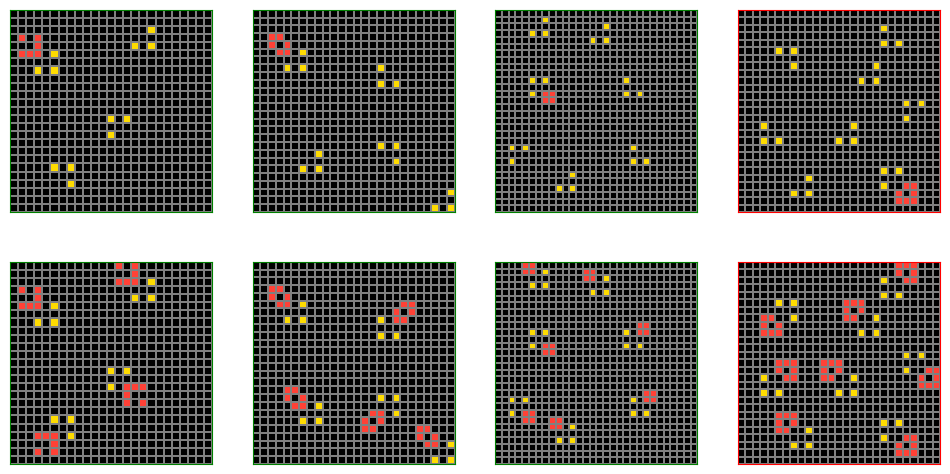

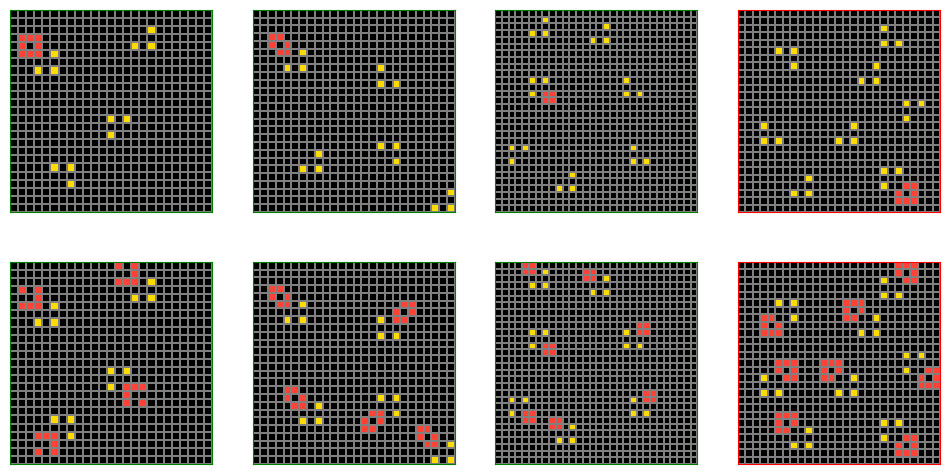

In [14]:
a = "ac0c5833"
for dss,chal in all_challenges[a].values():
    fig = plt.figure(figsize=(12,12))
    print(dss)
    tools.show_test_case(chal.train + chal.test,n_train=len(chal.train),orientation="h")

In [15]:
def treediff(a, b, *,path=()):
    ps = ".".join(path)
    ta = type(a)
    tb = type(b)
    if ta != tb:
        print(f"{ps}: type mismatch: {ta.__qualname__} != {tb.__qualname__}")
        return
    match a:
        case dict() | MappingProxyType():
            for k in set(a) | set(b):
                treediff(a.get(k), b.get(k), path=path+(k,))
        case list() | tuple():
            if len(a) != len(b):
                print(f"{ps}: length mismatch: {len(a)} != {len(b)}")
            else:
                for i,(av,bv) in enumerate(zip(a,b)):
                    treediff(av,bv,path=path+(str(i),))
        case np.ndarray():
            if a.shape != b.shape:
                print(f"{ps}: shape mismatch: {a.shape} != {b.shape}")
            elif np.any(a != b):
                print(f"{ps}: data mismatch: {np.sum(a != b)} / {a.size}")
        case _ if dataclasses.is_dataclass(ta):
            for f in dataclasses.fields(ta):
                k = f.name
                treediff(getattr(a,k),getattr(b,k),path=path+(k,))
        case _ if attrs.has(ta):
            for f in attrs.fields(ta):
                k = f.name
                treediff(getattr(a,k),getattr(b,k),path=path+(k,))
        case _:
            if a != b:
                print(f"{ps}: mismatch: {str(a)[:80]} != {str(b)[:80]}")
                
    
d = list(all_challenges[a].values())
treediff(d[0][1],d[1][1])


train.0.input.image._data: data mismatch: 2 / 625


In [16]:
treediff(ds,ds2)